#

# Series, or Open? How to maximize your rank points

## Imports and stuff

In [8]:
import random

from scipy.interpolate import make_interp_spline, BSpline  # Eventually for smoothing lines
import matplotlib.pyplot as plt

# Make plots bigger
plt.rcParams["figure.figsize"] = (12, 8)

## Constants
Let's start by defining all the relevant constants, which mostly depend on rank. I'm gonna use dictionaries here, with the rank names as keys.

In [2]:
# Open
POINTS_PER_OPEN_WIN = {
    "C-": 20,
    "C": 20,
    "C+": 20,
    "B-": 20,
    "B": 20,
    "B+": 20,
    "A-": 20,
    "A": 20,
    "A+": 20,
    "S": 20,
    "S+": 20,
}
POINTS_PER_OPEN_LOSS = {
    "C-": -3,
    "C": -3,
    "C+": -3,
    "B-": -5,
    "B": -5,
    "B+": -5,
    "A-": -8,
    "A": -8,
    "A+": -8,
    "S": -10,
    "S+": -13,
}

# Series
ENTRY_FEE = {
    "C-": 0,
    "C": -20,
    "C+": -40,
    "B-": -55,
    "B": -70,
    "B+": -85,
    "A-": -110,
    "A": -120,
    "A+": -130,
    "S": -170,
    "S+": -180,
}
SERIES_WIN_POINTS = {
    "C-": 20,
    "C": 20,
    "C+": 20,
    "B-": 30, 
    "B": 30,
    "B+": 30,
    "A-": 40,
    "A": 40,
    "A+": 40,
    "S": 50,
    "S+": 50,
}


## Simulation

In [ ]:
def simulate_series(
    rank: str, win_ratio: float, gold_medals: int, silver_medals: int
) -> tuple[int, int]:
    points = ENTRY_FEE[rank]

    # Calculate medal points
    assert gold_medals + silver_medals <= 3, "Total medals cannot exceed 3"
    medal_points = gold_medals * 5 + silver_medals * 1

    # Simulate until 5 wins or 3 losses
    wins = 0
    losses = 0
    while wins < 5 and losses < 3:
        if random.random() < win_ratio:
            # Win
            points += SERIES_WIN_POINTS[rank] + (wins * 5) + medal_points
            wins += 1
        else:
            # Loss
            losses += 1

    return (points, wins + losses)


def simulate_multiple_series(
    rank: str,
    win_ratio: float,
    gold_medals: int,
    silver_medals: int,
    epsilon: float = 1e-5,
    min_matches: int = 1000,
) -> tuple[float, int]:
    # Initialize variables and stuff
    total_points = 0
    total_matches = 0
    average = 1
    new_average = -1

    # Simulate until convergence and minimum matches reached
    while abs(average - new_average) > epsilon or total_matches < min_matches:
        average = new_average

        points, matches = simulate_series(
            rank,
            win_ratio,
            gold_medals,
            silver_medals,
        )
        total_points += points
        total_matches += matches

        new_average = total_points / total_matches

    return (new_average, total_matches)

We are only going to consider gold medals, since their weight (5 each) it's much more than the silver's (1 each)

In [ ]:
rank = "S+"

# medal_combinations = [(3, 0), (2, 1), (1, 2), (0, 3)] + [(2, 0), (1, 1), (0, 2)] + [(1, 0), (0, 1)] + [(0, 0)]
medal_combinations = [(3, 0), (2, 0), (1, 0), (0, 0)]
win_ratios = [i / 100 for i in range(0, 101)]

# This is much easier than series...
open_points = [POINTS_PER_OPEN_WIN[rank] * wr + POINTS_PER_OPEN_LOSS[rank] * (1 - wr) for wr in win_ratios]


In [27]:
# Let's simulate series with different medal and win ratio combinations
series_averages = []

for gold_medals, silver_medals in medal_combinations:
    average_points_list = []
    for wr in win_ratios:
        avg_points, _, _, _ = simulate_multiple_series(
            rank,
            wr,
            gold_medals,
            silver_medals,
            epsilon=1e-2,
            min_matches=25000,
        )
        average_points_list.append(avg_points)
    series_averages.append(average_points_list)

# Visualization

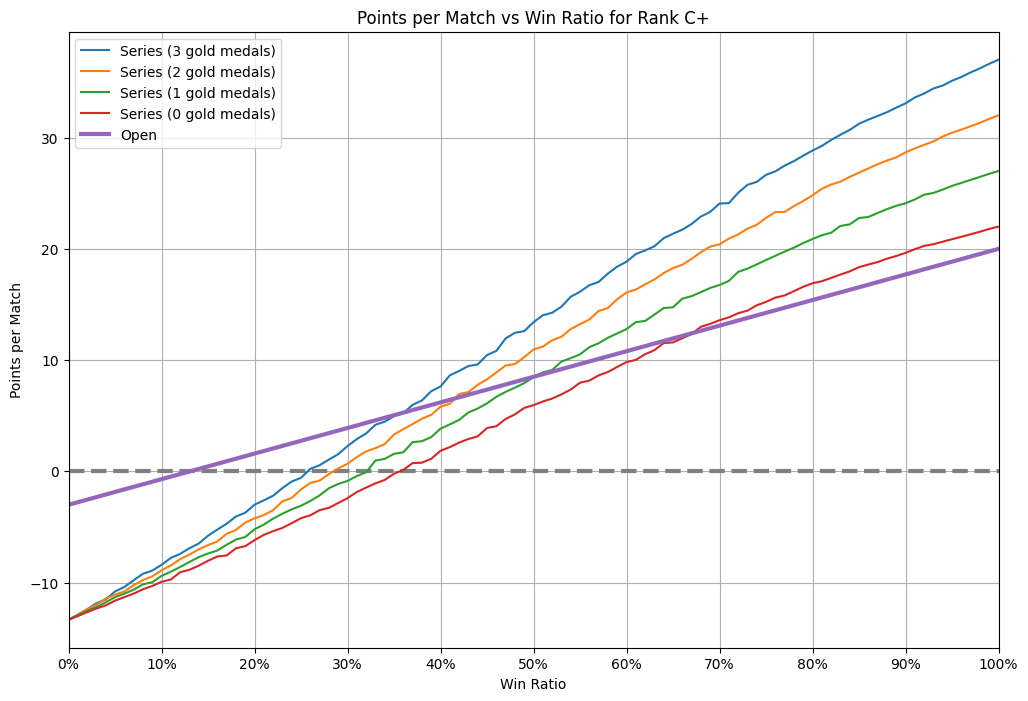

In [28]:
# Plot a horizontal red line at y=0
plt.axhline(0, color='grey', linestyle='--', linewidth=3)

# Plot the series lines
for (gold_medals, silver_medals), average_points_list in zip(medal_combinations, series_averages):
    # plt.plot(win_ratios, average_points_list, label=f"Series ({gold_medals} gold, {silver_medals} silver)")
    plt.plot(win_ratios, average_points_list, label=f"Series ({gold_medals} gold medals)")

# Plot the points per match for open
plt.plot(win_ratios, open_points, label="Open", linewidth=3)

# Labels and stuff
# plt.ylim(min(open_points), max(open_points))
plt.xlim(0, 1)
plt.xlabel("Win Ratio")
plt.xticks([i / 10 for i in range(0, 11)], [f"{i*10}%" for i in range(0, 11)])
plt.ylabel("Points per Match")
plt.title(f"Points per Match vs Win Ratio for Rank {rank}")
plt.legend()
plt.grid()
plt.show()

This is interesting, particularly how as the win ratio increases there seems to be diminishing returns.

My theory is that this is because medals in losses still give you points, which means that the more games the better. If you are winning a lot, you are just playing paying the entry fee for 5 games.

This doesn't include **throwing**, big TODO!